Here we'll explore how we can explore the interactions between the fly and the ball precisely

In [2]:
from utils_behavior import Sleap_utils
from utils_behavior import Ballpushing_utils
from matplotlib import pyplot as plt
import importlib

import numpy as np

In [ ]:
importlib.reload(Sleap_utils)

In [3]:
# Get some fly

Fly1 = Ballpushing_utils.Fly("/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231115_TNT_Fine_2_Videos_Tracked/arena9/corridor6/", as_individual=True)


In [4]:
# Check the ball images

Fly1.fly_skeleton

# Display the frame
#plt.imshow(some_frame)

,frame,time,object,x_Head,y_Head,x_Thorax,y_Thorax,x_Abdomen,y_Abdomen,x_Rfront,...,x_Lmid,y_Lmid,x_Rhind,y_Rhind,x_Lhind,y_Lhind,x_Rwing,y_Rwing,x_Lwing,y_Lwing
0,1,0.034483,fly_1,57.455917,388.273091,64.928861,394.060352,75.895535,403.306849,55.151600,...,87.766828,384.591616,91.575229,392.377867,54.831080,382.995934,88.810369,412.621368,56.538371,407.212202
1,2,0.068966,fly_1,57.510805,388.400650,64.935366,394.142799,75.812320,403.320089,55.210681,...,87.766828,384.591616,91.383685,392.466464,54.831080,382.995934,88.636561,412.568267,56.538371,407.212202
2,3,0.103448,fly_1,57.565692,388.528210,64.941871,394.225246,75.729106,403.333329,55.269762,...,87.766828,384.591616,91.192140,392.555062,54.831080,382.995934,88.462753,412.515167,56.538371,407.212202
3,4,0.137931,fly_1,57.620580,388.655769,64.948376,394.307693,75.645891,403.346568,55.328842,...,87.766828,384.591616,91.000596,392.643660,54.831080,382.995934,88.288945,412.462066,56.538371,407.212202
4,5,0.172414,fly_1,57.675468,388.783328,64.954881,394.390140,75.562677,403.359808,55.387923,...,87.766828,384.591616,90.809051,392.732258,54.831080,382.995934,88.115137,412.408966,56.538371,407.212202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104397,104398,3599.931034,fly_1,75.450094,151.973438,76.588968,164.451002,60.464414,187.067531,69.585263,...,56.394679,118.159847,73.969588,263.921224,55.299029,138.910192,71.225608,273.634950,63.643709,202.177225
104398,104399,3599.965517,fly_1,75.538659,151.241812,76.662850,163.723538,60.401104,186.355874,69.585263,...,56.394679,118.159847,73.969588,263.921224,55.299029,138.910192,71.225608,273.634950,63.578517,201.459421
104399,104400,3600.000000,fly_1,75.627224,150.510186,76.736733,162.996074,60.337794,185.644216,69.585263,...,56.394679,118.159847,73.969588,263.921224,55.299029,138.910192,71.225608,273.634950,63.513326,200.741618
104400,104401,3600.034483,fly_1,75.715789,149.778560,76.810616,162.268610,60.274484,184.932559,69.585263,...,56.394679,118.159847,73.969588,263.921224,55.299029,138.910192,71.225608,273.634950,63.448134,200.023814


In [8]:
# Get interaction events between fly Rfront and Lfront and ball centre

Events = Ballpushing_utils.find_interaction_events(Fly1.fly_skeleton, Fly1.balltrack.objects[0].dataset, ["Rfront", "Lfront"], ["centre"], threshold = [0,11], gap_between_events = 1/29, event_min_length = 1/29)

In [12]:
# For each event, get the derivative of the ball position

ball_velocities = []

for event in Events:
    # Get the ball positions for the event
    ball_positions = Fly1.balltrack.objects[0].dataset[event[0]:event[1]]
    # Get the derivative of the ball positions
    
    ball_velocity = abs(np.diff(ball_positions["y_centre"], axis = 0))
    
    ball_velocities.append(ball_velocity)
    
    

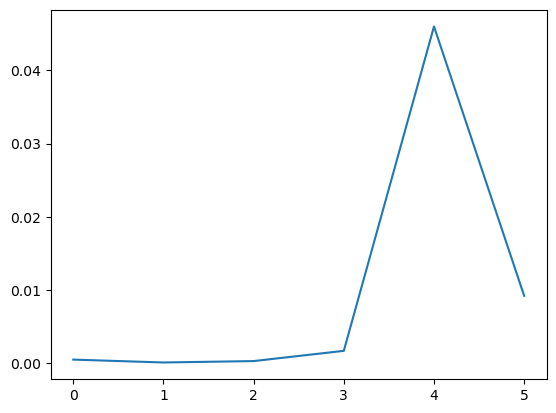

In [14]:
# Plot the ball velocities as a function of event number

plt.plot([np.mean(vel) for vel in ball_velocities])

In [18]:
# Get the annotated frames for event 4

for frame in range(Events[4][0], Events[4][1]):
    Fly1.flytrack.generate_annotated_frame(frame)

AttributeError: 'Sleap_Tracks' object has no attribute 'dataset'

In [ ]:
Dataset = Sleap_utils.CombinedSleapTracks(video_path="/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231115_TNT_Fine_2_Videos_Tracked/arena9/corridor6/corridor6_preprocessed.mp4", sleap_tracks_list=[Fly1, Ball1])

In [ ]:
FLytrack = Fly1.dataset

FLytrack.head()

In [ ]:
Balltrack = Ball1.dataset

Balltrack.head()

In [ ]:
# Define the threshold distance
threshold = 11

# Compute the Euclidean distance for Lfront and Rfront
distances_Lfront = np.sqrt((FLytrack["x_Lfront"] - Balltrack["x_centre"])**2 + (FLytrack["y_Lfront"] - Balltrack["y_centre"])**2)
distances_Rfront = np.sqrt((FLytrack["x_Rfront"] - Balltrack["x_centre"])**2 + (FLytrack["y_Rfront"] - Balltrack["y_centre"])**2)

# Find frames where either Lfront or Rfront is within the threshold distance
contacts = FLytrack[(distances_Lfront < threshold) | (distances_Rfront < threshold)]

In [ ]:
contacts

In [ ]:
# Display the frames where the fly is in contact with the ball

for index, row in contacts.iterrows():
    frame = Fly1.generate_annotated_frame(index)
    plt.imshow(frame)
    plt.show()
    #print(row)


In [ ]:
def find_contact_events(
        FLytrack,
        Balltrack,
        threshold=11,
        gap_between_events=4,
        event_min_length=2,
        fps=29
    ):
    """
    This function finds contact events where the fly's legs are touching the ball for a minimum amount of time.

    Parameters:
    FLytrack (DataFrame): DataFrame containing the fly's tracking data.
    Balltrack (DataFrame): DataFrame containing the ball's tracking data.
    threshold (int): The distance threshold (in pixels) for the fly's legs to be considered in contact with the ball.
    gap_between_events (int): The minimum gap required between two events, expressed in seconds.
    event_min_length (int): The minimum length of an event, expressed in seconds.
    fps (int): Frames per second of the video.

    Returns:
    list: A list of contact events, where each event is represented as [start_frame, end_frame, duration].
    """

    # Convert the gap between events and the minimum event length from seconds to frames
    gap_between_events = gap_between_events * fps
    event_min_length = event_min_length * fps

    # Compute the Euclidean distance for Lfront and Rfront
    distances_Lfront = np.sqrt((FLytrack["x_Lfront"] - Balltrack["x_centre"])**2 + (FLytrack["y_Lfront"] - Balltrack["y_centre"])**2)
    distances_Rfront = np.sqrt((FLytrack["x_Rfront"] - Balltrack["x_centre"])**2 + (FLytrack["y_Rfront"] - Balltrack["y_centre"])**2)

    # Find frames where either Lfront or Rfront is within the threshold distance
    contact_frames = np.where((distances_Lfront < threshold) | (distances_Rfront < threshold))[0]

    # If no contact frames are found, return an empty list
    if len(contact_frames) == 0:
        return []

    # Find the distance between consecutive contact frames
    distance_betw_frames = np.diff(contact_frames)

    # Find the points where the distance between frames is greater than the gap between events
    split_points = np.where(distance_betw_frames > gap_between_events)[0]

    # Add the first and last points to the split points
    split_points = np.insert(split_points, 0, -1)
    split_points = np.append(split_points, len(contact_frames) - 1)

    # Initialize the list of contact events
    contact_events = []

    # Iterate over the split points to find events
    for f in range(0, len(split_points) - 1):
        # Define the start and end of the region of interest (ROI)
        start_roi = contact_frames[split_points[f] + 1]
        end_roi = contact_frames[split_points[f + 1]]

        # Calculate the duration of the event
        duration = end_roi - start_roi

        # If the duration of the event is greater than the minimum length, add the event to the list
        if duration > event_min_length:
            contact_events.append([start_roi, end_roi, duration])

    return contact_events


In [ ]:
# Find contact events
contact_events = find_contact_events(FLytrack, Balltrack, threshold=16, gap_between_events=1/2, event_min_length=1/2, fps=29)

In [ ]:
contact_events

In [ ]:
# Make clips of the contact events

# Define the output directory
output_dir = "/mnt/upramdya_data/MD/Other_Videos/ContactDetection/Frontlegs_long"

# Make clips of the contact events
for i, event in enumerate(contact_events):
    # Define the start and end frames of the event
    start_frame = event[0]
    end_frame = event[1]

    # Define the output file name
    output_file = f"{output_dir}/contact_event_{i}.mp4"

    # Make the clip
    Fly1.generate_annotated_video(save=True, output_path=output_file, start=start_frame, end=end_frame)

In [ ]:
def find_contact_events(
        FLytrack,
        Balltrack,
        nodes=["Lfront", "Rfront"],
        threshold=11,
        gap_between_events=4,
        event_min_length=2,
        fps=29
    ):
    """
    This function finds contact events where the fly's specified nodes are touching the ball for a minimum amount of time.

    Parameters:
    FLytrack (DataFrame): DataFrame containing the fly's tracking data.
    Balltrack (DataFrame): DataFrame containing the ball's tracking data.
    nodes (list): List of nodes to check the distance with the ball (e.g., ["Lfront", "Rfront", "Head"]).
    threshold (int): The distance threshold (in pixels) for the fly's nodes to be considered in contact with the ball.
    gap_between_events (int): The minimum gap required between two events, expressed in seconds.
    event_min_length (int): The minimum length of an event, expressed in seconds.
    fps (int): Frames per second of the video.

    Returns:
    list: A list of contact events, where each event is represented as [start_frame, end_frame, duration].
    """

    # Convert the gap between events and the minimum event length from seconds to frames
    gap_between_events = gap_between_events * fps
    event_min_length = event_min_length * fps

    # Initialize a list to store distances for all specified nodes
    distances = []

    # Compute the Euclidean distance for each specified node
    for node in nodes:
        distances_node = np.sqrt((FLytrack[f"x_{node}"] - Balltrack["x_centre"])**2 + (FLytrack[f"y_{node}"] - Balltrack["y_centre"])**2)
        distances.append(distances_node)

    # Combine distances to find frames where any node is within the threshold distance
    combined_distances = np.min(distances, axis=0)
    contact_frames = np.where(combined_distances < threshold)[0]

    # If no contact frames are found, return an empty list
    if len(contact_frames) == 0:
        return []

    # Find the distance between consecutive contact frames
    distance_betw_frames = np.diff(contact_frames)

    # Find the points where the distance between frames is greater than the gap between events
    split_points = np.where(distance_betw_frames > gap_between_events)[0]

    # Add the first and last points to the split points
    split_points = np.insert(split_points, 0, -1)
    split_points = np.append(split_points, len(contact_frames) - 1)

    # Initialize the list of contact events
    contact_events = []

    # Iterate over the split points to find events
    for f in range(0, len(split_points) - 1):
        # Define the start and end of the region of interest (ROI)
        start_roi = contact_frames[split_points[f] + 1]
        end_roi = contact_frames[split_points[f + 1]]

        # Calculate the duration of the event
        duration = end_roi - start_roi

        # If the duration of the event is greater than the minimum length, add the event to the list
        if duration > event_min_length:
            contact_events.append([start_roi, end_roi, duration])

    return contact_events

In [ ]:
# Check head contacts
contact_events_head = find_contact_events(FLytrack, Balltrack, nodes=["Head"], threshold=16, gap_between_events=1/2, event_min_length=1/2, fps=29)

In [ ]:
contact_events_head

In [ ]:
# Make clips of the contact events

# Define the output directory
output_dir = "/mnt/upramdya_data/MD/Other_Videos/ContactDetection/Head"

# Make clips of the contact events
for i, event in enumerate(contact_events_head):
    # Define the start and end frames of the event
    start_frame = event[0]
    end_frame = event[1]

    # Define the output file name
    output_file = f"{output_dir}/contact_event_{i}.mp4"

    # Make the clip
    Fly1.generate_annotated_video(save=True, output_path=output_file, start=start_frame, end=end_frame)
    


In [ ]:
# Let's find contact events that would be in head but not in front legs

specific_contact_events = []

for event in contact_events_head:
    start_frame = event[0]
    end_frame = event[1]

    # Check if the event is in the front legs contact events
    is_in_front_legs = False
    for event_front_legs in contact_events:
        if start_frame >= event_front_legs[0] and end_frame <= event_front_legs[1]:
            is_in_front_legs = True
            break

    # If the event is not in the front legs contact events, add it to the specific contact events
    if not is_in_front_legs:
        specific_contact_events.append(event)
        
        
specific_contact_events

# Let's try connected components methods

In [ ]:
import cv2

def find_contact_events_connected_components(
        video_path,
        threshold=11,
        gap_between_events=4,
        event_min_length=2,
        fps=30
    ):
    """
    This function finds contact events where the fly's legs are touching the ball for a minimum amount of time using connected components analysis.

    Parameters:
    video_path (str): Path to the video file.
    threshold (int): The distance threshold (in pixels) for the fly's legs to be considered in contact with the ball.
    gap_between_events (int): The minimum gap required between two events, expressed in seconds.
    event_min_length (int): The minimum length of an event, expressed in seconds.
    fps (int): Frames per second of the video.

    Returns:
    list: A list of contact events, where each event is represented as [start_frame, end_frame, duration].
    """

    # Convert the gap between events and the minimum event length from seconds to frames
    gap_between_events = gap_between_events * fps
    event_min_length = event_min_length * fps

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return []

    # Initialize the list of contact events
    contact_events = []

    # Initialize variables to store the current event
    current_event_start = None
    current_event_end = None

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Threshold the image
        _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)

        # Check if there is only one shape (indicating contact)
        if num_labels == 2:  # Background + one shape
            if current_event_start is None:
                current_event_start = frame_count
            current_event_end = frame_count
        else:
            if current_event_start is not None:
                duration = current_event_end - current_event_start
                if duration > event_min_length:
                    contact_events.append([current_event_start, current_event_end, duration])
                current_event_start = None
                current_event_end = None

        frame_count += 1

    # Handle the last event if it was still ongoing
    if current_event_start is not None:
        duration = current_event_end - current_event_start
        if duration > event_min_length:
            contact_events.append([current_event_start, current_event_end, duration])

    cap.release()

    # Merge close events
    merged_events = []
    for event in contact_events:
        if not merged_events or event[0] - merged_events[-1][1] > gap_between_events:
            merged_events.append(event)
        else:
            merged_events[-1][1] = event[1]
            merged_events[-1][2] = merged_events[-1][1] - merged_events[-1][0]

    return merged_events

In [ ]:
import cv2
# Get a random frame from the video
video_path = "/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231115_TNT_Fine_2_Videos_Tracked/arena9/corridor6/corridor6_preprocessed.mp4"

cap = cv2.VideoCapture(video_path)

# Get the frame at 2109

cap.set(cv2.CAP_PROP_POS_FRAMES, 2109)

ret, frame = cap.read()

cap.release()

# Display the frame

plt.imshow(frame)


In [ ]:
def create_arena_mask(binary_frame, dilation_iterations=1):
    """Create a mask that keeps only the area inside the detected arena."""
    contours, _ = cv2.findContours(
        binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    mask = np.zeros_like(binary_frame)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
        
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return dilated_mask

In [ ]:
def binarise(frame, postpros = True):
    """Detect the corridors in a frame using a simple threshold."""
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    if postpros:
        kernel = np.ones((60, 20), np.uint8)  # Smaller kernel to avoid losing details
        closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    else:
        closing = binary

    return closing

In [ ]:
# Make  a mask of the arena
binary_frame = binarise(frame)

mask = create_arena_mask(binary_frame, dilation_iterations=0)

# Display the mask

plt.imshow(mask, cmap="gray")

In [ ]:
def adaptive_binarise(frame, block_size=11, c=2):
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
    
    binary = cv2.bitwise_not(binary)
    
    return binary

def apply_asymmetric_morphological_operations(binary_frame, kernel_size=2, open_iterations=1, close_iterations=2):
    # Create a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply morphological opening (erosion followed by dilation)
    opened_frame = cv2.morphologyEx(binary_frame, cv2.MORPH_OPEN, kernel, iterations=open_iterations)
    
    # Apply morphological closing (dilation followed by erosion)
    closed_frame = cv2.morphologyEx(opened_frame, cv2.MORPH_CLOSE, kernel, iterations=close_iterations)
    
    return closed_frame


# Apply adaptive thresholding to the frame
binary_frame = adaptive_binarise(frame, block_size=31, c=5)

# Apply asymmetric morphological operations to reduce noise and fill holes
processed_frame = apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=10)

# Apply the mask to the processed frame
masked_frame = cv2.bitwise_and(processed_frame, processed_frame, mask=mask)

# Display the masked frame
plt.imshow(masked_frame, cmap="gray")
plt.show()


In [ ]:
# Now we can detect inside the mask how many objects of a given size are present

def detect_objects(frame, min_area=500, max_area=1000):
    # Find contours in the frame
    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area
    objects = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            objects.append(contour)
    
    return objects

# Detect objects in the masked frame

objects = detect_objects(masked_frame, min_area=300, max_area=1000)

print(f"Number of objects detected: {len(objects)}")
# Draw the detected objects on the frame

frame_with_objects = cv2.drawContours(frame.copy(), objects, -1, (0, 255, 0), thickness=2)

# Display the frame with the detected objects

plt.imshow(frame_with_objects)

In [ ]:
# Apply this kind of treatment to 1000 frames to see how the video looks like

# Define the output directory
output_dir = "/mnt/upramdya_data/MD/Other_Videos/ContactDetection/ConnectedComponents"

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Pick start and end, and make a video with processed frames
start_frame = 10000
end_frame = 12000

# Set the frame position to the start frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Initialize the video writer
output_file = f"{output_dir}/processed_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = 29

# Get the frame size
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Process the frames
for frame_count in range(start_frame, end_frame):
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Threshold the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Create the arena mask
    mask = create_arena_mask(binary, dilation_iterations=0)

    # Apply adaptive thresholding to the frame
    binary_frame = adaptive_binarise(frame, block_size=31, c=5)

    # Apply asymmetric morphological operations to reduce noise and fill holes
    processed_frame = apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=10)

    # Apply the mask to the processed frame
    masked_frame = cv2.bitwise_and(processed_frame, processed_frame, mask=mask)

    # Detect objects in the masked frame
    objects = detect_objects(masked_frame, min_area=300, max_area=1000)

    # Draw the detected objects on the frame
    frame_with_objects = cv2.drawContours(frame.copy(), objects, -1, (0, 255, 0), thickness=2)

    # Write the frame to the output video
    out.write(frame_with_objects)

# Release the video capture and writer objects
cap.release()
out.release()

print("Video processing complete. Output saved to:", output_file)

In [ ]:
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize the list of contact events
contact_events = []

# Initialize variables to store the current event
current_event_start = None
current_event_end = None

event_min_length = 1
frame_count = 0
max_frames = 1000  # Process only the first 1000 frames

while frame_count < max_frames:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Threshold the image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply the mask to the frame
    masked_frame = cv2.bitwise_and(binary, binary, mask=mask)
    
    # Apply adaptive thresholding to the frame
    binary_frame = adaptive_binarise(frame, block_size=21, c=9)
    
    # Apply asymmetric morphological operations to reduce noise and fill holes
    processed_frame = apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=3)
    
    # Apply the mask to the processed frame
    masked_frame = cv2.bitwise_and(processed_frame, processed_frame, mask=mask)
    
    # Detect objects in the masked frame
    objects = detect_objects(masked_frame, min_area=300, max_area=1000)
    
    # Check if there is only one shape (indicating contact)
    if len(objects) == 1:
        if current_event_start is None:
            current_event_start = frame_count
        current_event_end = frame_count
    else:
        if current_event_start is not None:
            duration = current_event_end - current_event_start
            if duration > event_min_length:
                contact_events.append([current_event_start, current_event_end, duration])
            current_event_start = None
            current_event_end = None
    
    frame_count += 1

# Handle the last event if it was still ongoing
if current_event_start is not None:
    duration = current_event_end - current_event_start
    if duration > event_min_length:
        contact_events.append([current_event_start, current_event_end, duration])

cap.release()

print("Contact events:", contact_events)

In [ ]:
# Make clips of the contact events

# Define the output directory
output_dir = "/mnt/upramdya_data/MD/Other_Videos/ContactDetection/ConnectedComponents"

# Make clips of the contact events

for i, event in enumerate(contact_events):
    # Define the start and end frames of the event
    start_frame = event[0]
    end_frame = event[1]

    # Define the output file name
    output_file = f"{output_dir}/contact_event_{i}.mp4"

    # Make the clip
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Get the frame width and height
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_file, fourcc, 30, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
            break

        out.write(frame)

    cap.release()
    out.release()
    
    print(f"Saved contact event {i} to {output_file}")

In [ ]:
# Now let's first detect event where the fly is in contact with the ball and then crop the frames around the fly and the ball and apply the connected components analysis to detect contacts.

# Detect proximity events

# Define the threshold distance
threshold = 50

events = find_contact_events(FLytrack, Balltrack, threshold=threshold, gap_between_events=4, event_min_length=2, fps=29)

In [ ]:
# Take the first event and crop the frames around the fly and the ball

# Load the first frame of the video corresponding to the first event

# Get the first event
event = events[0]

# Get the start and end frames of the event

start_frame = event[0]

end_frame = event[1]

# Load the video

cap = cv2.VideoCapture(video_path)

# Set the frame position to the start frame

cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Read the frame

ret, frame = cap.read()

# Release the video capture object

cap.release()

# Display the frame

plt.imshow(frame)



In [ ]:
# Crop the frame around the fly and the ball so 50 pixels after the fly and 20 before the ball

# Get the fly and ball coordinates

fly_x = FLytrack.loc[event[0], "x_Thorax"]

fly_y = FLytrack.loc[event[0], "y_Thorax"]

ball_x = Balltrack.loc[event[0], "x_centre"]

ball_y = Balltrack.loc[event[0], "y_centre"]

# Define the crop box

crop_box = (int(fly_x - 15), int(ball_y - 50), int(fly_x + 15), int(fly_y + 50))

# Crop the frame

cropped_frame = frame[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2]]

# Display the cropped frame

plt.imshow(cropped_frame)

In [ ]:
# Try classic binarisation

# Apply binary thresholding to the cropped frame

binary_frame = cv2.threshold(cropped_frame, 80, 255, cv2.THRESH_BINARY )[1]

# invert the binary frame

binary_frame = cv2.bitwise_not(binary_frame)

# Display the binary frame

plt.imshow(binary_frame, cmap="gray")



In [ ]:
# Try adaptive binarisation

# Apply adaptive thresholding to the cropped frame

binary_frame = adaptive_binarise(cropped_frame, block_size=51, c=3)



# Display the binary frame

plt.imshow(binary_frame, cmap="gray")

In [ ]:
# Apply connected components analysis to the cropped frame

# Apply adaptive thresholding to the cropped frame

binary_frame = adaptive_binarise(cropped_frame, block_size=51, c=3)

# Apply asymmetric morphological operations to reduce noise and fill holes

processed_frame = apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=20)

# Apply connected components analysis to the processed frame

objects = detect_objects(processed_frame, min_area=300, max_area=2000)

# Draw the detected objects on the cropped frame

frame_with_objects = cv2.drawContours(cropped_frame.copy(), objects, -1, (0, 255, 0), thickness=2)

# Display the frame with the detected objects

plt.imshow(frame_with_objects)

In [ ]:
# 

In [ ]:
def adaptive_binarise(frame, block_size=31, c=5):
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
    
    # Invert the binary image
    binary = cv2.bitwise_not(binary)
    
    return binary

def apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=10):
    # Create a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply morphological opening (erosion followed by dilation)
    opened_frame = cv2.morphologyEx(binary_frame, cv2.MORPH_OPEN, kernel, iterations=open_iterations)
    
    # Apply morphological closing (dilation followed by erosion)
    closed_frame = cv2.morphologyEx(opened_frame, cv2.MORPH_CLOSE, kernel, iterations=close_iterations)
    
    return closed_frame

def detect_objects(frame, min_area=500, max_area=1000):
    # Find contours in the frame
    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area
    objects = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            objects.append(contour)
    
    return objects

def create_arena_mask(binary_frame, dilation_iterations=0):
    # Create a mask for the arena
    mask = np.zeros_like(binary_frame)
    contours, _ = cv2.findContours(binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return mask

def check_contact(binary_frame):
    # Perform connected component analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_frame)
    
    # Exclude the background label (0)
    num_objects = num_labels - 1
    
    # If there is only one object, the fly and the ball are touching
    if num_objects == 1:
        return True
    else:
        return False


output_dir = "/mnt/upramdya_data/MD/Other_Videos/ContactDetection/ConnectedComponents"

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get the total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Pick start and end, and make a video with processed frames
start_frame = 12000
end_frame = 13000

# Set the frame position to the start frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Initialize the video writer
output_file = f"{output_dir}/cropped_process_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
fps = 29

# Get the frame size
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

# Process the frames
for frame_count in range(start_frame, end_frame):
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply binary thresholding to the frame
    _, binary_frame = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)

    # Invert the binary frame
    binary_frame = cv2.bitwise_not(binary_frame)

    # Apply asymmetric morphological operations to reduce noise and fill holes
    processed_frame = apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=10)

    # Check if the fly and the ball are touching
    contact = check_contact(processed_frame)

    # Draw the result on the frame
    frame_with_contact = frame.copy()
    if contact:
        cv2.putText(frame_with_contact, "Contact", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    else:
        cv2.putText(frame_with_contact, "No Contact", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Write the frame to the output video
    out.write(frame_with_contact)

# Release the video capture and writer objects
cap.release()
out.release()

print("Video processing complete. Output saved to:", output_file)

In [ ]:
def adaptive_binarise(frame, block_size=31, c=5):
    if len(frame.shape) == 3:  # Convert to grayscale if needed
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    binary = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
    
    # Invert the binary image
    binary = cv2.bitwise_not(binary)
    
    return binary

def apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=10):
    # Create a kernel for morphological operations
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # Apply morphological opening (erosion followed by dilation)
    opened_frame = cv2.morphologyEx(binary_frame, cv2.MORPH_OPEN, kernel, iterations=open_iterations)
    
    # Apply morphological closing (dilation followed by erosion)
    closed_frame = cv2.morphologyEx(opened_frame, cv2.MORPH_CLOSE, kernel, iterations=close_iterations)
    
    return closed_frame

def detect_objects(frame, min_area=500, max_area=1000):
    # Find contours in the frame
    contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area
    objects = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            objects.append(contour)
    
    return objects

def create_arena_mask(binary_frame, dilation_iterations=0):
    # Create a mask for the arena
    mask = np.zeros_like(binary_frame)
    contours, _ = cv2.findContours(binary_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    
    if dilation_iterations > 0:
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=dilation_iterations)
    
    return mask

def check_contact(binary_frame):
    # Perform connected component analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_frame)
    
    # Exclude the background label (0)
    num_objects = num_labels - 1
    
    # If there is only one object, the fly and the ball are touching
    if num_objects == 1:
        return True
    else:
        return False

def find_contact_events(FLytrack, Balltrack, threshold=11, gap_between_events=4, event_min_length=2, fps=30):
    """
    This function finds contact events where the fly's legs are touching the ball for a minimum amount of time.

    Parameters:
    FLytrack (DataFrame): DataFrame containing the fly's tracking data.
    Balltrack (DataFrame): DataFrame containing the ball's tracking data.
    threshold (int): The distance threshold (in pixels) for the fly's legs to be considered in contact with the ball.
    gap_between_events (int): The minimum gap required between two events, expressed in seconds.
    event_min_length (int): The minimum length of an event, expressed in seconds.
    fps (int): Frames per second of the video.

    Returns:
    list: A list of contact events, where each event is represented as [start_frame, end_frame, duration].
    """

    # Convert the gap between events and the minimum event length from seconds to frames
    gap_between_events = gap_between_events * fps
    event_min_length = event_min_length * fps

    # Compute the Euclidean distance for Lfront and Rfront
    distances_Lfront = np.sqrt((FLytrack["x_Lfront"] - Balltrack["x_centre"])**2 + (FLytrack["y_Lfront"] - Balltrack["y_centre"])**2)
    distances_Rfront = np.sqrt((FLytrack["x_Rfront"] - Balltrack["x_centre"])**2 + (FLytrack["y_Rfront"] - Balltrack["y_centre"])**2)

    # Find frames where either Lfront or Rfront is within the threshold distance
    contact_frames = np.where((distances_Lfront < threshold) | (distances_Rfront < threshold))[0]

    # If no contact frames are found, return an empty list
    if len(contact_frames) == 0:
        return []

    # Find the distance between consecutive contact frames
    distance_betw_frames = np.diff(contact_frames)

    # Find the points where the distance between frames is greater than the gap between events
    split_points = np.where(distance_betw_frames > gap_between_events)[0]

    # Add the first and last points to the split points
    split_points = np.insert(split_points, 0, -1)
    split_points = np.append(split_points, len(contact_frames) - 1)

    # Initialize the list of contact events
    contact_events = []

    # Iterate over the split points to find events
    for f in range(0, len(split_points) - 1):
        # Define the start and end of the region of interest (ROI)
        start_roi = contact_frames[split_points[f] + 1]
        end_roi = contact_frames[split_points[f + 1]]

        # Calculate the duration of the event
        duration = end_roi - start_roi

        # If the duration of the event is greater than the minimum length, add the event to the list
        if duration > event_min_length:
            contact_events.append([start_roi, end_roi, duration])

    return contact_events

output_dir = "/mnt/upramdya_data/MD/Other_Videos/ContactDetection/ConnectedComponents"

# Detect proximity events
threshold = 50
events = find_contact_events(FLytrack, Balltrack, threshold=threshold, gap_between_events=4, event_min_length=2, fps=29)

# Process each event
for event in events:
    start_frame = event[0]
    end_frame = event[1]

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    # Set the frame position to the start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # Initialize the video writer
    output_file = f"{output_dir}/processed_event_{start_frame}_{end_frame}.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    fps = 29

    # Get the frame size
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

    # Process the frames for the current event
    for frame_count in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Ensure the frame is grayscale
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Get the fly and ball coordinates
        fly_x = FLytrack.loc[frame_count, "x_Thorax"]
        fly_y = FLytrack.loc[frame_count, "y_Thorax"]
        ball_x = Balltrack.loc[frame_count, "x_centre"]
        ball_y = Balltrack.loc[frame_count, "y_centre"]
        
        # Get the center of the frame
        center_x = frame.shape[1] // 2

        # Define the crop box
        crop_x1 = max(0, int(center_x - 15))
        crop_y1 = max(0, int(ball_y - 50))
        crop_x2 = min(frame.shape[1], int(center_x + 15))
        crop_y2 = min(frame.shape[0], int(fly_y + 50))

        # Crop the frame
        cropped_frame = frame[crop_y1:crop_y2, crop_x1:crop_x2]

        # Check if the cropped frame is empty
        if cropped_frame.size == 0:
            continue

        # Apply binary thresholding to the cropped frame
        _, binary_frame = cv2.threshold(cropped_frame, 80, 255, cv2.THRESH_BINARY)

        # Invert the binary frame
        binary_frame = cv2.bitwise_not(binary_frame)

        # Apply asymmetric morphological operations to reduce noise and fill holes
        processed_frame = apply_asymmetric_morphological_operations(binary_frame, kernel_size=1, open_iterations=1, close_iterations=10)

        # Check if the fly and the ball are touching
        contact = check_contact(processed_frame)

        # Draw a green or red circle on the top of the frame based on the contact
        
        frame_with_contact = frame.copy()
        if contact:
            cv2.circle(frame_with_contact, (center_x, int((crop_y1 + crop_y2) / 2)), 10, (0, 255, 0), -1)
        else:
            cv2.circle(frame_with_contact, (center_x, int((crop_y1 + crop_y2) / 2)), 10, (0, 0, 255), -1)

        # Write the frame to the output video
        out.write(frame_with_contact)

    # Release the video capture and writer objects
    cap.release()
    out.release()

print("Video processing complete. Output saved to:", output_dir)